In [2]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
from gmm_dataset import *
from util_hmm_variational_gibbs import *
from util_plots import *
from scipy.stats import invwishart, dirichlet
from torch.distributions.dirichlet import Dirichlet
sys.path.append('/home/hao/Research/probtorch/')
from probtorch.util import expand_inputs
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.0.0a0+1e8064d cuda: False


In [3]:
T = 30
K = 3
D = 2
num_particles_rws = 10
mcmc_steps = 10
num_particles_smc = 20
NUM_HIDDEN = 128
NUM_LATENTS = K*K
NUM_OBS = 2 * K
# training parameters
NUM_SAMPLES = 1
# BATCH_SIZE = 100
NUM_EPOCHS = 40
LEARNING_RATE = 1e-2
CUDA = False

RESTORE = False

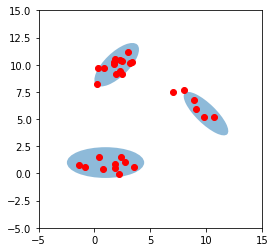

In [4]:
Xs, mu_true, cov_true, Zs_true, Pi_true, A_true = sampling_hmm(T, K, D)
plot_samples(Xs.data.numpy(), mu_true.data.numpy(), cov_true.data.numpy())
Y = Xs

In [5]:
## return samples in order to compute the weights and 
class Encoder(nn.Module):
    def __init__(self, num_obs=NUM_OBS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_hidden = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU())
        self.latent_dir = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
    def forward(self, obs, num_particles=1):
        A_samples = torch.zeros((K, K))
        hidden = self.enc_hidden(obs)
        latents_dirs = torch.exp(self.latent_dir(hidden)).sum(0).view(K, K)
        for k in range(K):
            A_samples[k] = Dirichlet(latents_dirs[k]).sample()
        return latents_dirs, A_samples

In [6]:
def initialize():
    enc = Encoder()
    if CUDA:
        enc.cuda()
    optimizer =  torch.optim.Adam(list(enc.parameters()),lr=LEARNING_RATE)    
    return enc, optimizer

alpha_init_0, alpha_trans_0, m_0, beta_0, nu_0, W_0 = pirors(Y, T, D, K)
enc, optimizer = initialize()
## initialization
# cov_ks = torch.zeros((K, D, D))
# mu_ks = torch.zeros((K, D))
# for k in range(K):
# ## sample mu_k and Sigma_k randomly
#     cov_ks[k] = torch.from_numpy(invwishart.rvs(df=nu_0, scale=W_0.data.numpy())).float()
#     mu_ks[k] = MultivariateNormal(loc=m_0, covariance_matrix=cov_ks[k] / beta_0).sample()
# Pi = Dirichlet(alpha_init_0).sample()
A_samples = initial_trans(alpha_trans_0, K)

In [ ]:
KLs = []
KL_ests = []
log_p_conds = []
log_qs = []
ESSs = []

Pi = Pi_true
mu_ks = mu_true
cov_ks = cov_true

for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    optimizer.zero_grad()
    log_weights_rws = torch.zeros(num_particles_rws)
    log_qs = torch.zeros(num_particles_rws)
    log_p_conds = torch.zeros(num_particles_rws)
    kl = 0.0
    for l in range(num_particles_rws):
        # initialize A from prior
#         A_samples = initial_trans(alpha_trans_0, K)
        # SMC to generate a weighted sample set for local states
        Zs, log_weights, log_normalizer = smc_hmm(Pi, A_samples, mu_ks, cov_ks, Y, T, D, K, num_particles_smc)
        # draw a sample from the sample set 
        Z_ret = resampling_smc(Zs, log_weights)
        log_weight_rws = log_normalizer
        Z_ret_pairwise = torch.cat((Z_ret[:T-1].unsqueeze(0), Z_ret[1:].unsqueeze(0)), 0).transpose(0, 1).contiguous().view(T-1, 2*K)
        for m in range(mcmc_steps):
            A_prev = A_samples
            # pair (Zs_max, normalizer) is p.w. w.r.t. q_smc
            latents_dirs, A_samples = enc(Z_ret_pairwise, 1)
#             print('=====epoch : %d, rws : %d, mcmc : %d =====' % (epoch, l, m))
#             print(A_samples)
            log_p_joint_curr = log_joint(alpha_init_0, alpha_trans_0, nu_0, W_0, m_0, beta_0, Z_ret, Pi, A_samples, mu_ks, cov_ks, Y, T, D, K).detach().item()
            log_p_joint_prev = log_joint(alpha_init_0, alpha_trans_0, nu_0, W_0, m_0, beta_0, Z_ret, Pi, A_prev, mu_ks, cov_ks, Y, T, D, K).detach().item() 
            
            log_q_curr = log_q_hmm(latents_dirs, A_samples, K, num_particles=1).detach()
            log_q_prev = log_q_hmm(latents_dirs, A_prev, K,num_particles=1).detach()
            
            Zs, log_weights, log_normalizer = csmc_hmm(Z_ret, Pi, A_samples, mu_ks, cov_ks, Y, T, D, K, num_particles_smc)
            Z_ret = resampling_smc(Zs, log_weights)
            Z_ret_pairwise = torch.cat((Z_ret[:T-1].unsqueeze(0), Z_ret[1:].unsqueeze(0)), 0).transpose(0, 1).contiguous().view(T-1, 2*K)
            log_weight_rws += log_p_joint_curr - log_p_joint_prev - log_q_curr + log_q_prev
              
        log_weights_rws[l] = log_weight_rws.detach()     
        
        
        log_p_cond = torch.zeros(K)
        alpha_trans_hat = alpha_trans_0 + pairwise(Z_ret, T).sum(0)
        kl += kl_dirichlets(alpha_trans_0, latents_dirs, Z_ret, T, K)
#         for k in range(K):
#             log_p_cond[k] = Dirichlet(alpha_trans_hat[k]).log_prob(A_samples[k])

#         log_p_conds[l] = log_p_cond.sum(0)        
        log_qs[l] = log_q_hmm(latents_dirs, A_samples, K, num_particles=1)
#     print('rws : %d, log_q : %f' % (l, log_qs[l]))    
    kl /= num_particles_rws
        
    log_weights_rws = log_weights_rws - log_sum_exp(log_weights_rws)
    weights_rws = torch.exp(log_weights_rws)
    ess = (1. / (weights_rws ** 2 ).sum()).item()
    loss_infer = - torch.mul(weights_rws, log_qs).sum()
#     kl_est = torch.mul(weights_rws, log_p_conds - log_qs).sum().detach().item()
    loss_infer.backward()
    KLs.append(kl.item())
#     KL_ests.append(kl_est)
    ESSs.append(ess)
    optimizer.step()
    
    latents_dirs, A_samples = enc(Z_ret_pairwise, 1)
    A_samples = A_samples.detach()
    time_end = time.time()
    print('epoch : %d, KL : %f (%ds)' % (epoch, kl,time_end - time_start))

In [ ]:
plot_kl_est(np.array(KLs), np.array(KL_ests))

In [ ]:
alpha_trans_0 + pairwise(Zs_true, T).sum(0)

In [ ]:
learned_dicichlet_post = latents_dirs
true_dirichlet_post = alpha_trans_0 + pairwise(Z_ret, T).sum(0)
print('variational : ')
print(learned_dicichlet_post)
print('conjugate posterior :')
print(true_dirichlet_post)

In [ ]:
plt.plot(np.array(ESSs) / num_particles_rws)

In [ ]:
from torch.distributions.categorical import Categorical
Categorical(torch.Tensor([1/2, 1/2])).sample()

In [ ]:
a = torch.Tensor([1,2,3,4,5])

In [ ]:
output, (hn, cn) = enc.enc_lstm(Z_ret.unsqueeze(1))

In [ ]:
cn.shape